In [3]:
import networkx as nx
import pickle as pk
import random
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import torch

C:\Users\Soham\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torch_geometric.utils import from_networkx

In [20]:
!pwd
with open("Main_graph_withNodeFeats.pkl", "rb") as f:
    G = pk.load(f)

/c/Users/Soham/OneDrive/Desktop


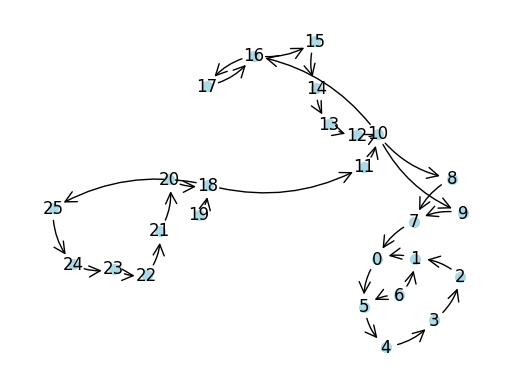

In [21]:
pos = nx.spring_layout(G)

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12)

curved_edges = list(G.edges())
arc_rad = 0.2  # curvature radius
nx.draw_networkx_edges(G, pos, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}', arrowstyle='->', arrowsize=20)

plt.axis('off')
plt.show()

In [22]:
data = from_networkx(G)

In [23]:
def draw_graph(data, index):
    graph = to_networkx(data[index])
    nx.draw(graph, with_labels = True)

In [24]:
def generate_connected_subgraphs(G, k, n, seed=None):
    if seed is not None:
        random.seed(seed)

    if G.number_of_nodes() <= k:
        raise ValueError("Cannot remove more nodes than exist in the graph.")

    attempts = 0
    max_attempts = 100 * n  # safety to avoid infinite loops
    subgraphs = []


    while len(subgraphs) < n and attempts < max_attempts:
        attempts += 1
        nodes_to_remove = random.sample(list(G.nodes()), k)
        G_sub = G.copy()
        G_sub.remove_nodes_from(nodes_to_remove)

        if nx.is_weakly_connected(G_sub):
            subgraphs.append(G_sub)

    if len(subgraphs) < n:
        print(f"Warning: Only found {len(subgraphs)} connected subgraphs after {attempts} attempts.")

    return subgraphs
'''
    # Plotting
    fig, axes = plt.subplots(1, len(subgraphs), figsize=(5 * len(subgraphs), 5))
    if len(subgraphs) == 1:
        axes = [axes]
    for i, sg in enumerate(subgraphs):
        pos = nx.spring_layout(sg, seed=42)  # Layout specific to the subgraph

        # Draw nodes and labels for the subgraph
        nx.draw_networkx_nodes(sg, pos, node_size=50, node_color='lightblue', ax=axes[i])
        nx.draw_networkx_labels(sg, pos, font_size=12, ax=axes[i])

        # Draw directed edges with curved arrows
        curved_edges = list(sg.edges())
        arc_rad = 0.2  # curvature radius
        nx.draw_networkx_edges(
            sg, pos,
            edgelist=curved_edges,
            connectionstyle=f'arc3, rad = {arc_rad}',
            arrowstyle='->', arrowsize=20,
            ax=axes[i]
        )

        axes[i].set_title(f'Subgraph {i+1}')
        axes[i].axis('off')  # Optional: hide axis ticks
    plt.show()
'''


"\n    # Plotting\n    fig, axes = plt.subplots(1, len(subgraphs), figsize=(5 * len(subgraphs), 5))\n    if len(subgraphs) == 1:\n        axes = [axes]\n    for i, sg in enumerate(subgraphs):\n        pos = nx.spring_layout(sg, seed=42)  # Layout specific to the subgraph\n\n        # Draw nodes and labels for the subgraph\n        nx.draw_networkx_nodes(sg, pos, node_size=50, node_color='lightblue', ax=axes[i])\n        nx.draw_networkx_labels(sg, pos, font_size=12, ax=axes[i])\n\n        # Draw directed edges with curved arrows\n        curved_edges = list(sg.edges())\n        arc_rad = 0.2  # curvature radius\n        nx.draw_networkx_edges(\n            sg, pos,\n            edgelist=curved_edges,\n            connectionstyle=f'arc3, rad = {arc_rad}',\n            arrowstyle='->', arrowsize=20,\n            ax=axes[i]\n        )\n\n        axes[i].set_title(f'Subgraph {i+1}')\n        axes[i].axis('off')  # Optional: hide axis ticks\n    plt.show()\n"

In [25]:
graph_ls = []
subgraph_ls = []
for k in range(5):
    subgraphs = generate_connected_subgraphs(G, k, n=10, seed=123)
    subgraph_ls.append(subgraphs)

subgraph_ls = [g for graphs in subgraph_ls for g in graphs]


In [26]:
graph_data_obj_ls = []
for nx_graph in subgraph_ls:
    graph_data_obj = from_networkx(nx_graph)
    graph_data_obj_ls.append(graph_data_obj)

In [27]:
len(graph_data_obj_ls)

50

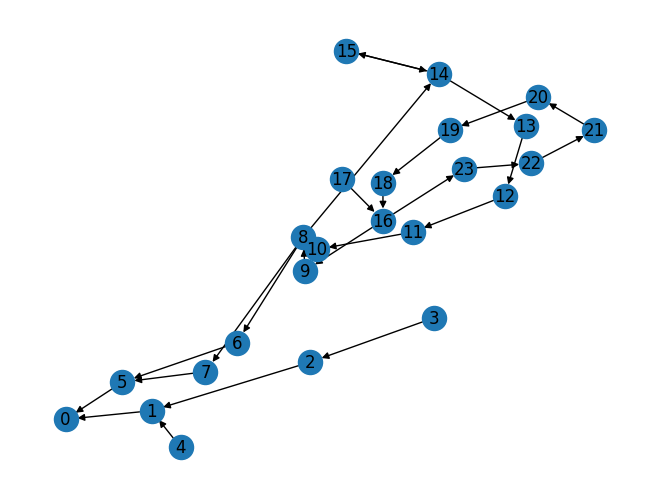

In [28]:
draw_graph(graph_data_obj_ls, 24)

In [29]:
import random
import copy
import numpy as np


In [50]:
TOTAL_NODES = 26 

for data in graph_data_obj_ls:
    num_nodes = data.num_nodes
    data.x = torch.eye(TOTAL_NODES)[:num_nodes] 

In [51]:
'''
subgraph_data_obj_ls = []

for data in graph_data_obj_ls:
    # Convert to NetworkX graph
    G_nx = to_networkx(data, to_undirected=False)
    
    # Compute rank of the incidence matrix
    incidence_matrix = nx.incidence_matrix(G_nx, oriented=True).toarray()
    rank = np.linalg.matrix_rank(incidence_matrix)
    
    num_edges = data.edge_index.size(1)
    
    for edges_to_remove in range(rank, min(rank + 6, num_edges)):
        for _ in range(15):  # generate 15 graphs per mask level
            if num_edges <= edges_to_remove:
                continue  # skip if not enough edges to remove
            
            data_copy = copy.deepcopy(data)
            
            # Randomly sample edge indices to remove
            edge_indices = list(range(num_edges))
            to_remove = random.sample(edge_indices, edges_to_remove)
            
            # Create boolean mask
            mask = torch.ones(num_edges, dtype=torch.bool)
            mask[to_remove] = False
            
            # Apply mask to edge_index and edge_attr
            data_copy.edge_index = data.edge_index[:, mask]
            
            if hasattr(data, 'edge_attr') and data.edge_attr is not None:
                data_copy.edge_attr = data.edge_attr[mask]
            
            # Append masked graph
            subgraph_data_obj_ls.append(data_copy)
'''

"\nsubgraph_data_obj_ls = []\n\nfor data in graph_data_obj_ls:\n    # Convert to NetworkX graph\n    G_nx = to_networkx(data, to_undirected=False)\n    \n    # Compute rank of the incidence matrix\n    incidence_matrix = nx.incidence_matrix(G_nx, oriented=True).toarray()\n    rank = np.linalg.matrix_rank(incidence_matrix)\n    \n    num_edges = data.edge_index.size(1)\n    \n    for edges_to_remove in range(rank, min(rank + 6, num_edges)):\n        for _ in range(15):  # generate 15 graphs per mask level\n            if num_edges <= edges_to_remove:\n                continue  # skip if not enough edges to remove\n            \n            data_copy = copy.deepcopy(data)\n            \n            # Randomly sample edge indices to remove\n            edge_indices = list(range(num_edges))\n            to_remove = random.sample(edge_indices, edges_to_remove)\n            \n            # Create boolean mask\n            mask = torch.ones(num_edges, dtype=torch.bool)\n            mask[to_re

In [52]:
def generate_masked_dataset(graph_data_obj_ls):
    import copy, random
    import numpy as np
    import torch
    import networkx as nx
    from torch_geometric.utils import to_networkx

    masked_graphs = []
    mask_info = []  # [(masked_edges, all_possible_edges)] per masked graph

    for data in graph_data_obj_ls:
        G_nx = to_networkx(data, to_undirected=False)
        incidence_matrix = nx.incidence_matrix(G_nx, oriented=True).toarray()
        rank = np.linalg.matrix_rank(incidence_matrix)
        num_edges = data.edge_index.size(1)

        for edges_to_remove in range(rank, min(rank + 6, num_edges)):
            for _ in range(15):
                if num_edges <= edges_to_remove:
                    continue

                data_copy = copy.deepcopy(data)

                edge_indices = list(range(num_edges))
                to_remove = random.sample(edge_indices, edges_to_remove)
                mask = torch.ones(num_edges, dtype=torch.bool)
                mask[to_remove] = False

                data_copy.edge_index = data.edge_index[:, mask]
                if hasattr(data, 'edge_attr') and data.edge_attr is not None:
                    data_copy.edge_attr = data.edge_attr[mask]
                num_nodes = data.num_nodes
                data_copy.x = torch.eye(TOTAL_NODES)[:num_nodes]

                masked_edges = data.edge_index[:, to_remove].t().tolist()

                all_edges = [[i, j] for i in range(data.num_nodes) for j in range(data.num_nodes) if i != j]

                masked_graphs.append(data_copy)
                mask_info.append((masked_edges, all_edges))

    return masked_graphs, mask_info


In [53]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import VGAE, GCNConv

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logvar = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logvar(x, edge_index)

In [54]:
from sklearn.model_selection import train_test_split

def split_dataset(masked_graphs, masked_info, test_size=0.2, seed=42):
    indices = list(range(len(masked_graphs)))
    train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=seed)

    train_graphs = [masked_graphs[i] for i in train_idx]
    train_info = [masked_info[i] for i in train_idx]

    test_graphs = [masked_graphs[i] for i in test_idx]
    test_info = [masked_info[i] for i in test_idx]

    return (train_graphs, train_info), (test_graphs, test_info)

In [55]:
def train_and_evaluate_vgae(train_set, test_set, node_feat_dim, epochs=100, lr=0.01, device='cpu'):
    train_graphs, train_info = train_set
    test_graphs, test_info = test_set

    model = VGAE(GCNEncoder(node_feat_dim, out_channels=64)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for i, g_data in enumerate(train_graphs):
            masked_edges, all_possible_edges = train_info[i]
            if not masked_edges:
                continue

            g_data = g_data.to(device)
            optimizer.zero_grad()

            z = model.encode(g_data.x, g_data.edge_index)

            negatives = random.sample(
                [e for e in all_possible_edges if e not in masked_edges and e not in g_data.edge_index.t().tolist()],
                k=len(masked_edges)
            )

            edge_index = torch.tensor(masked_edges + negatives, dtype=torch.long).t().contiguous().to(device)
            labels = torch.tensor([1]*len(masked_edges) + [0]*len(negatives), dtype=torch.float).to(device)

            pred = model.decoder(z, edge_index)
            loss = F.binary_cross_entropy_with_logits(pred, labels)
            loss += (1 / g_data.num_nodes) * model.kl_loss()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # ---- Evaluation ----
        model.eval()
        total_test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for i, g_data in enumerate(test_graphs):
                masked_edges, all_possible_edges = test_info[i]
                if not masked_edges:
                    continue

                g_data = g_data.to(device)
                z = model.encode(g_data.x, g_data.edge_index)

                negatives = random.sample(
                    [e for e in all_possible_edges if e not in masked_edges and e not in g_data.edge_index.t().tolist()],
                    k=len(masked_edges)
                )

                edge_index = torch.tensor(masked_edges + negatives, dtype=torch.long).t().contiguous().to(device)
                labels = torch.tensor([1]*len(masked_edges) + [0]*len(negatives), dtype=torch.float).to(device)

                preds = model.decoder(z, edge_index)
                loss = F.binary_cross_entropy_with_logits(preds, labels)
                total_test_loss += loss.item()

                predicted = (preds.sigmoid() > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += len(labels)

        acc = correct / total if total > 0 else 0
        print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} | Test Loss: {total_test_loss:.4f} | Test Acc: {acc:.4f}")

    return model



In [56]:
masked_graphs, masked_info = generate_masked_dataset(graph_data_obj_ls)

(train_graphs, train_info), (test_graphs, test_info) = split_dataset(masked_graphs, masked_info)

model = train_and_evaluate_vgae(
    train_set=(train_graphs, train_info),
    test_set=(test_graphs, test_info),
    node_feat_dim=graph_data_obj_ls[0].num_node_features,
    epochs=50,
    lr=0.005,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


[Epoch 1] Train Loss: 1790.1149 | Test Loss: 433.0666 | Test Acc: 0.5000
[Epoch 2] Train Loss: 1787.2252 | Test Loss: 432.9156 | Test Acc: 0.5000
[Epoch 3] Train Loss: 1790.9922 | Test Loss: 432.7476 | Test Acc: 0.5000
[Epoch 4] Train Loss: 1790.3703 | Test Loss: 432.8868 | Test Acc: 0.5000


KeyboardInterrupt: 